In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the dataset
df = pd.read_csv('data/Sleep_health_and_lifestyle_dataset.csv')

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

Dataset Shape: (374, 13)

Column Names:
['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

First 5 rows:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                      

In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check data types and unique values
print("\nUnique values in categorical columns:")
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

# Check target variable distribution
print(f"\nStress Level Statistics:")
print(df['Stress Level'].describe())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Missing Values:
Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

Unique values in categorical columns:
Gender: ['Male' 'Female']
Occupation: ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
BMI Category: ['Overweight' 'Normal' 'Obese' 'Normal Weight']
Sleep Disorder: [nan 'Sleep Apnea' 'Insomnia']

Stress Level Statistics:
count    374.000000
mean       5.385027
std        1.774526
min        3.000000
25%        4.000000
50%        5.000000
75%        7.000000
max        8.000000
Name: Stress Level, dtype: float64

Duplicate rows: 0


In [4]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle Blood Pressure - split into systolic and diastolic
df_processed[['Systolic_BP', 'Diastolic_BP']] = df_processed['Blood Pressure'].str.split('/', expand=True).astype(int)

# Create BMI categories as numerical (ordinal encoding makes sense here)
bmi_mapping = {'Normal': 0, 'Normal Weight': 0, 'Overweight': 1, 'Obese': 2}
df_processed['BMI_Numeric'] = df_processed['BMI Category'].map(bmi_mapping)

# Encode Gender
df_processed['Gender_Numeric'] = LabelEncoder().fit_transform(df_processed['Gender'])

# Create occupation groups (based on stress patterns observed)
high_stress_occupations = ['Doctor', 'Nurse', 'Lawyer', 'Software Engineer']
medium_stress_occupations = ['Teacher', 'Accountant', 'Engineer', 'Salesperson', 'Sales Representative']
low_stress_occupations = ['Manager', 'Scientist']

def categorize_occupation(occupation):
    if occupation in high_stress_occupations:
        return 2  # High stress occupation
    elif occupation in medium_stress_occupations:
        return 1  # Medium stress occupation
    else:
        return 0  # Low stress occupation

df_processed['Occupation_Stress_Level'] = df_processed['Occupation'].apply(categorize_occupation)

# Handle Sleep Disorder - convert to binary (has disorder or not)
df_processed['Has_Sleep_Disorder'] = (df_processed['Sleep Disorder'] != 'None').astype(int)

# Create additional features
df_processed['Sleep_Efficiency'] = df_processed['Quality of Sleep'] / df_processed['Sleep Duration']
df_processed['Activity_to_Steps_Ratio'] = df_processed['Physical Activity Level'] / (df_processed['Daily Steps'] / 1000)
df_processed['BP_Product'] = df_processed['Systolic_BP'] * df_processed['Diastolic_BP'] / 1000

print("Feature engineering completed!")
print(f"New dataset shape: {df_processed.shape}")

Feature engineering completed!
New dataset shape: (374, 22)


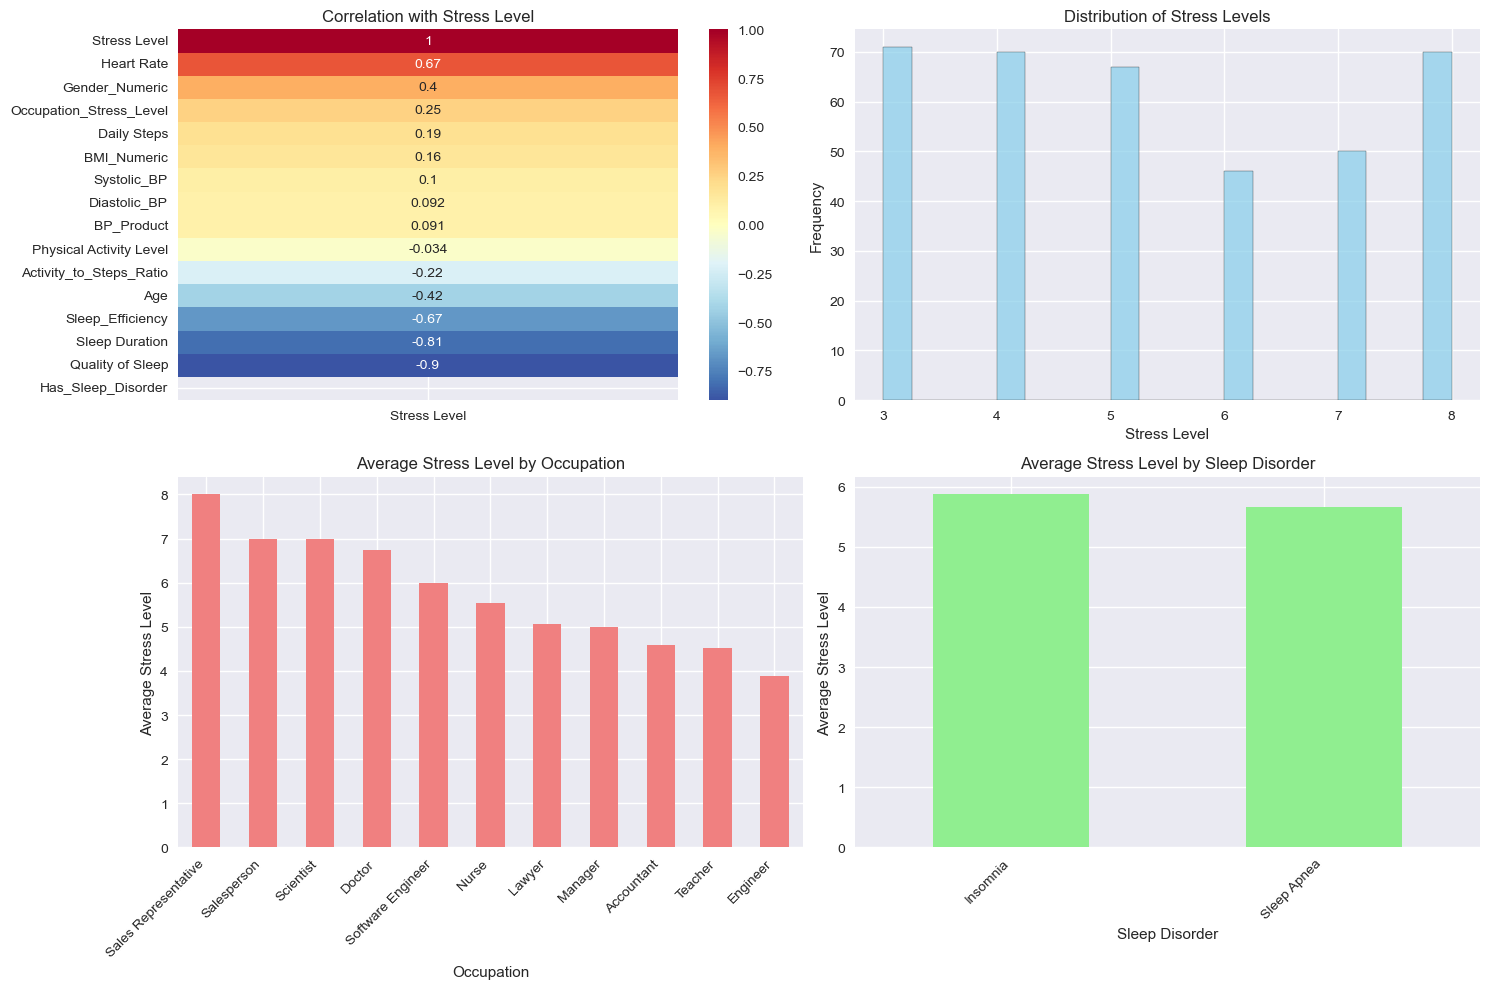

Top correlations with Stress Level:
Quality of Sleep: 0.899
Sleep Duration: 0.811
Sleep_Efficiency: 0.671
Heart Rate: 0.670
Age: 0.422
Gender_Numeric: 0.396
Occupation_Stress_Level: 0.255
Activity_to_Steps_Ratio: 0.223
Daily Steps: 0.187
BMI_Numeric: 0.158
Systolic_BP: 0.103
Diastolic_BP: 0.092
BP_Product: 0.091
Physical Activity Level: 0.034
Has_Sleep_Disorder: nan


In [5]:
# Correlation with target variable
plt.figure(figsize=(15, 10))

# Select numerical features for correlation analysis
numerical_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                     'BMI_Numeric', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP',
                     'Gender_Numeric', 'Occupation_Stress_Level', 'Has_Sleep_Disorder',
                     'Sleep_Efficiency', 'Activity_to_Steps_Ratio', 'BP_Product']

correlation_data = df_processed[numerical_features + ['Stress Level']].corr()

# Plot correlation heatmap
plt.subplot(2, 2, 1)
sns.heatmap(correlation_data[['Stress Level']].sort_values('Stress Level', ascending=False), 
            annot=True, cmap='RdYlBu_r', center=0)
plt.title('Correlation with Stress Level')

# Distribution of stress levels
plt.subplot(2, 2, 2)
plt.hist(df_processed['Stress Level'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level')
plt.ylabel('Frequency')

# Stress level by occupation
plt.subplot(2, 2, 3)
occupation_stress = df_processed.groupby('Occupation')['Stress Level'].mean().sort_values(ascending=False)
occupation_stress.plot(kind='bar', color='lightcoral')
plt.title('Average Stress Level by Occupation')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Stress Level')

# Stress level by sleep disorder
plt.subplot(2, 2, 4)
disorder_stress = df_processed.groupby('Sleep Disorder')['Stress Level'].mean()
disorder_stress.plot(kind='bar', color='lightgreen')
plt.title('Average Stress Level by Sleep Disorder')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Stress Level')

plt.tight_layout()
plt.show()

# Print correlation values
print("Top correlations with Stress Level:")
stress_correlations = correlation_data['Stress Level'].abs().sort_values(ascending=False)
for feature, corr in stress_correlations.items():
    if feature != 'Stress Level':
        print(f"{feature}: {corr:.3f}")

In [6]:
# Prepare features for modeling
feature_columns = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                  'BMI_Numeric', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP',
                  'Gender_Numeric', 'Occupation_Stress_Level', 'Has_Sleep_Disorder',
                  'Sleep_Efficiency', 'Activity_to_Steps_Ratio', 'BP_Product']

X = df_processed[feature_columns]
y = df_processed['Stress Level']

# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = [feature_columns[i] for i in selector.get_support(indices=True)]
feature_scores = selector.scores_

print("Feature Selection Results:")
print("Selected Features and their F-scores:")
for i, (feature, score) in enumerate(zip(feature_columns, feature_scores)):
    status = "✓ SELECTED" if feature in selected_features else "✗ Not selected"
    print(f"{feature}: {score:.2f} {status}")

print(f"\nFinal selected features ({len(selected_features)}):")
for feature in selected_features:
    print(f"- {feature}")

Feature Selection Results:
Selected Features and their F-scores:
Age: 80.76 ✓ SELECTED
Sleep Duration: 714.95 ✓ SELECTED
Quality of Sleep: 1563.03 ✓ SELECTED
Physical Activity Level: 0.43 ✗ Not selected
BMI_Numeric: 9.48 ✓ SELECTED
Heart Rate: 303.06 ✓ SELECTED
Daily Steps: 13.45 ✓ SELECTED
Systolic_BP: 3.97 ✗ Not selected
Diastolic_BP: 3.16 ✗ Not selected
Gender_Numeric: 69.19 ✓ SELECTED
Occupation_Stress_Level: 25.84 ✓ SELECTED
Has_Sleep_Disorder: 0.00 ✗ Not selected
Sleep_Efficiency: 304.87 ✓ SELECTED
Activity_to_Steps_Ratio: 19.45 ✓ SELECTED
BP_Product: 3.09 ✗ Not selected

Final selected features (10):
- Age
- Sleep Duration
- Quality of Sleep
- BMI_Numeric
- Heart Rate
- Daily Steps
- Gender_Numeric
- Occupation_Stress_Level
- Sleep_Efficiency
- Activity_to_Steps_Ratio


In [7]:
# Use selected features
X_final = df_processed[selected_features]
y_final = df_processed['Stress Level']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=pd.cut(y_final, bins=3))

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Feature names: {selected_features}")

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=selected_features)

Training set size: (299, 10)
Test set size: (75, 10)
Feature names: ['Age', 'Sleep Duration', 'Quality of Sleep', 'BMI_Numeric', 'Heart Rate', 'Daily Steps', 'Gender_Numeric', 'Occupation_Stress_Level', 'Sleep_Efficiency', 'Activity_to_Steps_Ratio']


In [8]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, gamma='scale')
}

# Train and evaluate models
results = {}
cv_results = {}

print("Model Training and Cross-Validation Results:")
print("=" * 60)

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    # Store results
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name}:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print("-" * 40)

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
print(f"\nBest Model: {best_model_name}")
print(f"Best Test R²: {results[best_model_name]['test_r2']:.4f}")

Model Training and Cross-Validation Results:
Linear Regression:
  Train R²: 0.9641
  Test R²: 0.9185
  Test RMSE: 0.5259
  Test MAE: 0.2847
  CV R² (mean ± std): 0.9574 ± 0.0079
----------------------------------------
Ridge Regression:
  Train R²: 0.9568
  Test R²: 0.9120
  Test RMSE: 0.5464
  Test MAE: 0.3192
  CV R² (mean ± std): 0.9498 ± 0.0061
----------------------------------------
Random Forest:
  Train R²: 0.9986
  Test R²: 0.9217
  Test RMSE: 0.5156
  Test MAE: 0.1687
  CV R² (mean ± std): 0.9822 ± 0.0133
----------------------------------------
Gradient Boosting:
  Train R²: 0.9998
  Test R²: 0.9237
  Test RMSE: 0.5089
  Test MAE: 0.1582
  CV R² (mean ± std): 0.9851 ± 0.0116
----------------------------------------
Support Vector Regression:
  Train R²: 0.9915
  Test R²: 0.9193
  Test RMSE: 0.5234
  Test MAE: 0.2288
  CV R² (mean ± std): 0.9724 ± 0.0087
----------------------------------------

Best Model: Gradient Boosting
Best Test R²: 0.9237


In [9]:
# Hyperparameter tuning for the best performing model
best_model = models[best_model_name]

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Support Vector Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'epsilon': [0.01, 0.1, 0.2]
    }
else:
    param_grid = {}

if param_grid:
    print(f"Performing hyperparameter tuning for {best_model_name}...")
    
    grid_search = GridSearchCV(
        estimator=best_model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Use the best model
    best_tuned_model = grid_search.best_estimator_
else:
    print(f"No hyperparameter tuning defined for {best_model_name}")
    best_tuned_model = best_model

Performing hyperparameter tuning for Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.9857


FINAL MODEL PERFORMANCE
Model: Gradient Boosting
R² Score: 0.9241
RMSE: 0.5076
MAE: 0.1482
Accuracy (based on R²): 92.41%

FEATURE IMPORTANCE:
------------------------------
Sleep_Efficiency: 0.3952
Quality of Sleep: 0.2232
Heart Rate: 0.2130
Sleep Duration: 0.1108
Gender_Numeric: 0.0209
Activity_to_Steps_Ratio: 0.0193
Occupation_Stress_Level: 0.0087
Daily Steps: 0.0051
Age: 0.0037
BMI_Numeric: 0.0001


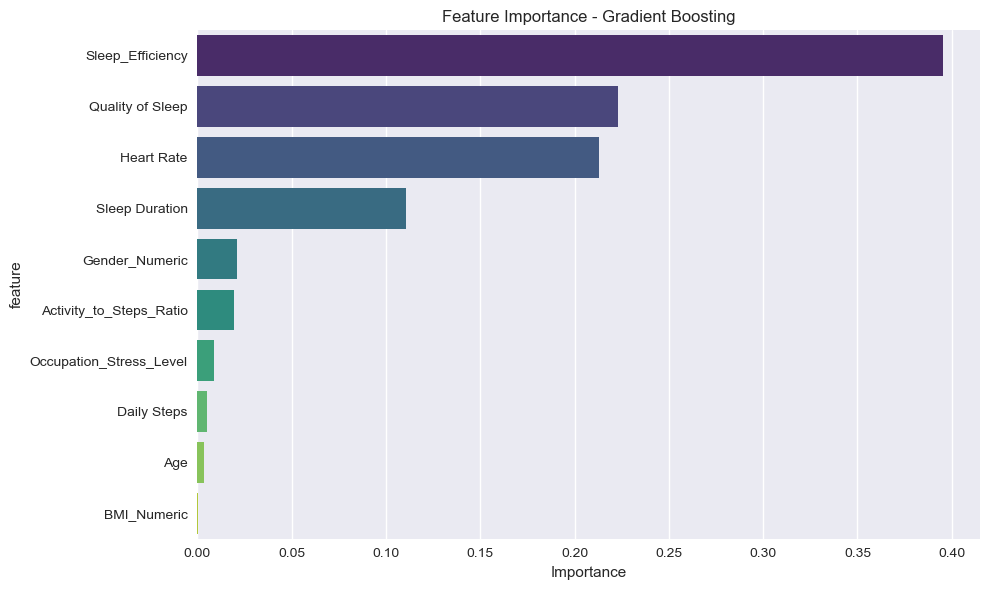

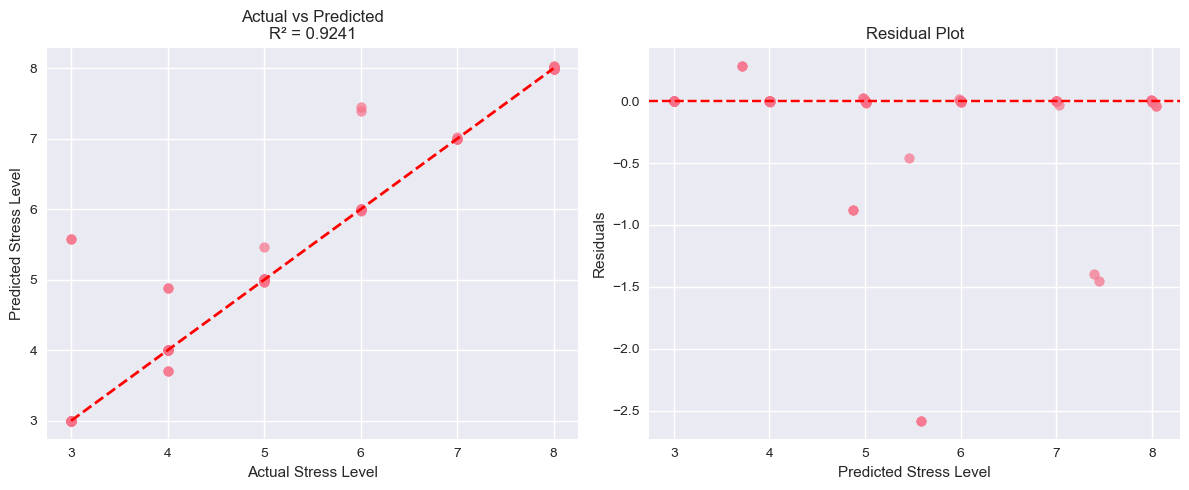

In [10]:
# Final predictions with tuned model
y_pred_final = best_tuned_model.predict(X_test_scaled)

# Calculate final metrics
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_mae = mean_absolute_error(y_test, y_pred_final)

print("FINAL MODEL PERFORMANCE")
print("=" * 40)
print(f"Model: {best_model_name}")
print(f"R² Score: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"Accuracy (based on R²): {final_r2*100:.2f}%")

# Feature importance (if available)
if hasattr(best_tuned_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_tuned_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFEATURE IMPORTANCE:")
    print("-" * 30)
    for _, row in feature_importance.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Prediction vs Actual plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_final, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stress Level')
plt.ylabel('Predicted Stress Level')
plt.title(f'Actual vs Predicted\nR² = {final_r2:.4f}')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_final
plt.scatter(y_pred_final, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Stress Level')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

In [11]:
# Create a summary of insights
print("MODEL INSIGHTS AND INTERPRETATION")
print("=" * 50)

# Stress level ranges
stress_ranges = {
    'Low Stress (1-3)': (df_processed['Stress Level'] <= 3).sum(),
    'Medium Stress (4-6)': ((df_processed['Stress Level'] > 3) & (df_processed['Stress Level'] <= 6)).sum(),
    'High Stress (7-10)': (df_processed['Stress Level'] > 6).sum()
}

print("Dataset Distribution:")
for range_name, count in stress_ranges.items():
    percentage = (count / len(df_processed)) * 100
    print(f"  {range_name}: {count} samples ({percentage:.1f}%)")

print(f"\nModel Performance Summary:")
print(f"  • The model can explain {final_r2*100:.1f}% of the variance in stress levels")
print(f"  • Average prediction error: ±{final_mae:.2f} stress level points")
print(f"  • Root Mean Square Error: {final_rmse:.2f}")

if hasattr(best_tuned_model, 'feature_importances_'):
    top_3_features = feature_importance.head(3)
    print(f"\nTop 3 Most Important Factors for Predicting Stress:")
    for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
        print(f"  {i}. {row['feature']} (importance: {row['importance']:.3f})")

# Practical recommendations based on feature importance
print(f"\nPractical Insights:")
if 'Quality of Sleep' in selected_features:
    print("  • Sleep quality is a key predictor of stress levels")
if 'Physical Activity Level' in selected_features:
    print("  • Physical activity levels significantly impact stress")
if 'Occupation_Stress_Level' in selected_features:
    print("  • Occupation type is strongly associated with stress levels")
if 'Has_Sleep_Disorder' in selected_features:
    print("  • Sleep disorders are important indicators of stress")

MODEL INSIGHTS AND INTERPRETATION
Dataset Distribution:
  Low Stress (1-3): 71 samples (19.0%)
  Medium Stress (4-6): 183 samples (48.9%)
  High Stress (7-10): 120 samples (32.1%)

Model Performance Summary:
  • The model can explain 92.4% of the variance in stress levels
  • Average prediction error: ±0.15 stress level points
  • Root Mean Square Error: 0.51

Top 3 Most Important Factors for Predicting Stress:
  1. Sleep_Efficiency (importance: 0.395)
  2. Quality of Sleep (importance: 0.223)
  3. Heart Rate (importance: 0.213)

Practical Insights:
  • Sleep quality is a key predictor of stress levels
  • Occupation type is strongly associated with stress levels


In [12]:
import joblib
import numpy as np
import pandas as pd
import os

# Create directory if not exists
os.makedirs('stress_models', exist_ok=True)

# Save model artifacts (checking global scope for variables)
try:
    # Check if required variables exist
    if 'best_tuned_model' in globals() and 'scaler' in globals():
        # Save model and scaler
        joblib.dump(best_tuned_model, 'stress_models/stress_prediction_model.joblib')
        joblib.dump(scaler, 'stress_models/feature_scaler.joblib')
        
        # Prepare metadata
        metadata = {
            'selected_features': selected_features,
            'bmi_mapping': bmi_mapping,
            'gender_mapping': {'Female': 0, 'Male': 1},
            'occupation_categories': {
                'high_stress': high_stress_occupations,
                'medium_stress': medium_stress_occupations
            }
        }
        
        joblib.dump(metadata, 'stress_models/model_metadata.joblib')
        
        print("✅ Model artifacts saved successfully in 'stress_models' directory!")
        print("Files saved:")
        print("- stress_prediction_model.joblib")
        print("- feature_scaler.joblib")
        print("- model_metadata.joblib")
    else:
        print("⚠️ Model or scaler not found. Make sure you've run the training cells first.")
        print("Skipping model save operation.")
except Exception as e:
    print(f"❌ Error saving model: {e}")

# Define prediction function
def predict_stress_level(input_data):
    """
    Predict stress level for new input data
    
    Parameters:
    input_data: dict containing:
        - age: Age of the person
        - sleep_duration: Hours of sleep
        - quality_of_sleep: Sleep quality (1-10)
        - physical_activity_level: Physical activity level (0-100)
        - bmi_category: 'Normal', 'Overweight', or 'Obese'
        - heart_rate: Heart rate (bpm)
        - daily_steps: Daily steps count
        - systolic_bp: Systolic blood pressure
        - diastolic_bp: Diastolic blood pressure
        - gender: 'Male' or 'Female'
        - occupation: Occupation string
        - has_sleep_disorder: True/False for sleep disorder
    
    Returns:
    - Predicted stress level (float)
    """
    try:
        # Load artifacts
        model = joblib.load('stress_models/stress_prediction_model.joblib')
        scaler = joblib.load('stress_models/feature_scaler.joblib')
        metadata = joblib.load('stress_models/model_metadata.joblib')
        
        # Apply preprocessing
        bmi_numeric = metadata['bmi_mapping'].get(input_data['bmi_category'], 0)
        gender_numeric = metadata['gender_mapping'].get(input_data['gender'], 0)
        
        # Map occupation stress
        occupation_stress = 0
        if input_data['occupation'] in metadata['occupation_categories']['high_stress']:
            occupation_stress = 2
        elif input_data['occupation'] in metadata['occupation_categories']['medium_stress']:
            occupation_stress = 1
        
        # Calculate derived features
        sleep_duration = input_data['sleep_duration']
        quality_of_sleep = input_data['quality_of_sleep']
        daily_steps = input_data['daily_steps']
        physical_activity = input_data['physical_activity_level']
        systolic_bp = input_data['systolic_bp']
        diastolic_bp = input_data['diastolic_bp']
        
        sleep_efficiency = quality_of_sleep / sleep_duration if sleep_duration > 0 else 0
        activity_ratio = physical_activity / (daily_steps/1000) if daily_steps > 0 else 0
        bp_product = (systolic_bp * diastolic_bp) / 1000
        
        # Create feature dictionary
        features = {
            'Age': input_data['age'],
            'Sleep Duration': sleep_duration,
            'Quality of Sleep': quality_of_sleep,
            'Physical Activity Level': physical_activity,
            'BMI_Numeric': bmi_numeric,
            'Heart Rate': input_data['heart_rate'],
            'Daily Steps': daily_steps,
            'Systolic_BP': systolic_bp,
            'Diastolic_BP': diastolic_bp,
            'Gender_Numeric': gender_numeric,
            'Occupation_Stress_Level': occupation_stress,
            'Has_Sleep_Disorder': int(input_data['has_sleep_disorder']),
            'Sleep_Efficiency': sleep_efficiency,
            'Activity_to_Steps_Ratio': activity_ratio,
            'BP_Product': bp_product
        }
        
        # Create feature vector in correct order
        feature_vector = [features[col] for col in metadata['selected_features']]
        
        # Scale and predict
        scaled_features = scaler.transform([feature_vector])
        prediction = model.predict(scaled_features)[0]
        return round(prediction, 2)
    
    except Exception as e:
        print(f"🚨 Prediction error: {str(e)}")
        return None

# Test prediction if model exists
if os.path.exists('stress_models/stress_prediction_model.joblib'):
    print("\n🧪 Testing prediction with sample data:")
    test_data = {
        'age': 42,
        'sleep_duration': 6.5,
        'quality_of_sleep': 7,
        'physical_activity_level': 65,
        'bmi_category': 'Overweight',
        'heart_rate': 75,
        'daily_steps': 7500,
        'systolic_bp': 130,
        'diastolic_bp': 85,
        'gender': 'Female',
        'occupation': 'Nurse',
        'has_sleep_disorder': True
    }
    
    result = predict_stress_level(test_data)
    if result is not None:
        print(f"📊 Test prediction result: {result}")
    else:
        print("❌ Prediction test failed")
else:
    print("⏩ Skipping prediction test - no model found")

✅ Model artifacts saved successfully in 'stress_models' directory!
Files saved:
- stress_prediction_model.joblib
- feature_scaler.joblib
- model_metadata.joblib

🧪 Testing prediction with sample data:
📊 Test prediction result: 6.81
